In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Read the root directory of images and extract pixel features and flatten into a 1d vector

In [2]:
dataset_path = 'Lab 2 Data' 
features = []
labels = []

# Loop over each subject folder
for subject_folder in sorted(os.listdir(dataset_path)):
    if subject_folder.startswith('s'):
        subject_number = int(subject_folder[1:])  
        subject_path = os.path.join(dataset_path, subject_folder)

        # Loop over each image in the subject folder
        for image_file in sorted(os.listdir(subject_path)):
            if image_file.endswith('.pgm'):
                image_path = os.path.join(subject_path, image_file)
                
                # Load the image
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Flatten the image to 1D vector
                flattened_vector = img_array.flatten()

                # Append data and label
                features.append(flattened_vector)
                labels.append(subject_number)

features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)      

Features shape: (400, 10304)
Labels shape: (400,)


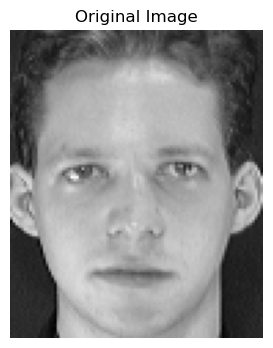

In [7]:
img  = features[0]

original = features[0].reshape(112,92)  # Assuming ORL face dataset shape

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.show()

### Split Data into Odd indexed rows for training and even indexed for testing

In [3]:
X_train = features[::2]
X_test  = features[1::2] 
y_train = labels[::2]
y_test  = labels[1::2]

In [4]:
import numpy as np

class PCA:
    def __init__(self, alpha=0.95):
        self.alpha = alpha
        self.cov_matrix = None
        self.eigen_vals = None
        self.eigen_vecs = None
        self.k = None
        self.top_k_vecs = None
        self.mu = None

    def _calculate_covariance(self, X):
        # Compute mean and center data
        self.mu = np.mean(X, axis=0)
        X_centered = X - self.mu
        # Use unbiased estimator: divide by n-1
        cov = (1.0 / (X_centered.shape[0] - 1)) * (X_centered.T @ X_centered)
        return cov

    def fit(self, X):
        # Fit PCA: compute covariance, eigen decomposition, sort, and save
        self.cov_matrix = self._calculate_covariance(X)
        self.eigen_vals, self.eigen_vecs = np.linalg.eigh(self.cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_vals)[::-1]
        self.eigen_vals = self.eigen_vals[idx]
        self.eigen_vecs = self.eigen_vecs[:, idx]

        # Save for later use
        np.save('eigen_vals.npy', self.eigen_vals)
        np.save('eigen_vecs.npy', self.eigen_vecs)
        np.save('mean_vector.npy', self.mu)
        
        self.set_alpha(self.alpha)

    def load_eigen(self):
        # Load precomputed eigenvalues, eigenvectors, and mean
        self.eigen_vals = np.load('eigen_vals.npy')
        self.eigen_vecs = np.load('eigen_vecs.npy')
        self.mu = np.load('mean_vector.npy')

    def set_alpha(self, alpha):
        # Set variance threshold and compute top-k components
        self.alpha = alpha
        cum_var = np.cumsum(self.eigen_vals)
        total = cum_var[-1]
        ratio = cum_var / total
        self.k = np.searchsorted(ratio, self.alpha) + 1
        self.top_k_vecs = self.eigen_vecs[:, :self.k]

    def transform(self, X):
        X_centered = X - self.mu
        return X_centered @ self.top_k_vecs

    def fit_transform(self, X):
        self.fit(X)
        self.set_alpha(self.alpha)
        return self.transform(X)

    def inverse_transform(self, Z):
        self.set_alpha(self.alpha)
        return (Z @ self.top_k_vecs.T) + self.mu


Alpha: 0.8
Number of principal components retained: 44
Reduced feature shape: (400, 44)


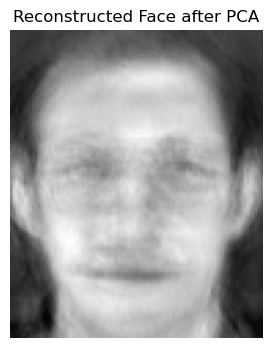

Alpha: 0.85
Number of principal components retained: 68
Reduced feature shape: (400, 68)


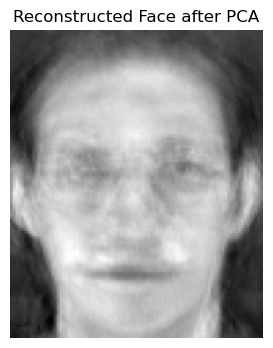

Alpha: 0.9
Number of principal components retained: 111
Reduced feature shape: (400, 111)


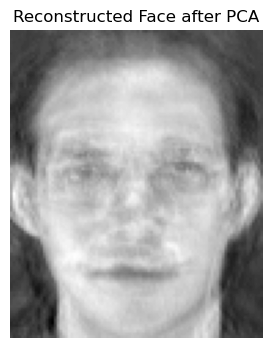

Alpha: 0.95
Number of principal components retained: 190
Reduced feature shape: (400, 190)


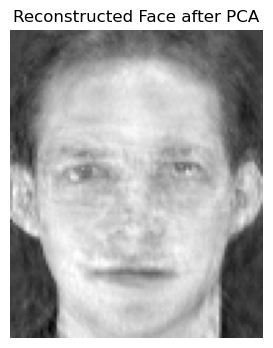

In [5]:
pca = PCA()

pca.load_eigen()

alphas = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas:
    pca.set_alpha(alpha)
    reduced_features = pca.transform(features)
    
    print(f"Alpha: {alpha}")
    print(f"Number of principal components retained: {pca.k}")
    print(f"Reduced feature shape: {reduced_features.shape}")

    samples = reduced_features[0:1]

    for sample in samples:
        plt.figure(figsize=(8, 4))
        
        reconstructed_sample = pca.inverse_transform(sample)
        
        reconstructed_sample = reconstructed_sample.reshape(112, 92)

        plt.imshow(reconstructed_sample, cmap='gray')
        plt.title("Reconstructed Face after PCA")
        plt.axis('off')
        plt.show()

## Bonus: Design an autoencouder NN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10304, 5152),
            nn.ReLU(),
            nn.Linear(5152, 2576),
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(2576, 5152),
            nn.ReLU(),
            nn.Linear(5152, 10304),
            nn.Sigmoid()        
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
def train(lr= 0.0005, epochs = 100,features = None):
    features = features.astype(np.float32) 
    features /= 255.0
    
    # Convert features to a Tensor
    features_tensor = torch.from_numpy(features)
    dataset = TensorDataset(features_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = AutoEncoder(input_size=10304)  # Make sure to pass input size if needed
    
    Loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch[0].to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = Loss(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    return model    

In [10]:
model = train(epochs = 200,features= features)

Epoch [1/200], Loss: 0.053180
Epoch [2/200], Loss: 0.028499
Epoch [3/200], Loss: 0.025155
Epoch [4/200], Loss: 0.024279
Epoch [5/200], Loss: 0.023281
Epoch [6/200], Loss: 0.023393
Epoch [7/200], Loss: 0.022805
Epoch [8/200], Loss: 0.022708
Epoch [9/200], Loss: 0.022737
Epoch [10/200], Loss: 0.022656
Epoch [11/200], Loss: 0.022739
Epoch [12/200], Loss: 0.022491
Epoch [13/200], Loss: 0.022416
Epoch [14/200], Loss: 0.021813
Epoch [15/200], Loss: 0.024724
Epoch [16/200], Loss: 0.023245
Epoch [17/200], Loss: 0.022574
Epoch [18/200], Loss: 0.023316
Epoch [19/200], Loss: 0.023226
Epoch [20/200], Loss: 0.022815
Epoch [21/200], Loss: 0.022082
Epoch [22/200], Loss: 0.020453
Epoch [23/200], Loss: 0.020017
Epoch [24/200], Loss: 0.018854
Epoch [25/200], Loss: 0.018212
Epoch [26/200], Loss: 0.017684
Epoch [27/200], Loss: 0.017414
Epoch [28/200], Loss: 0.016873
Epoch [29/200], Loss: 0.015983
Epoch [30/200], Loss: 0.015493
Epoch [31/200], Loss: 0.015382
Epoch [32/200], Loss: 0.015395
Epoch [33/200], L

In [28]:
# store pickle file
import pickle
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

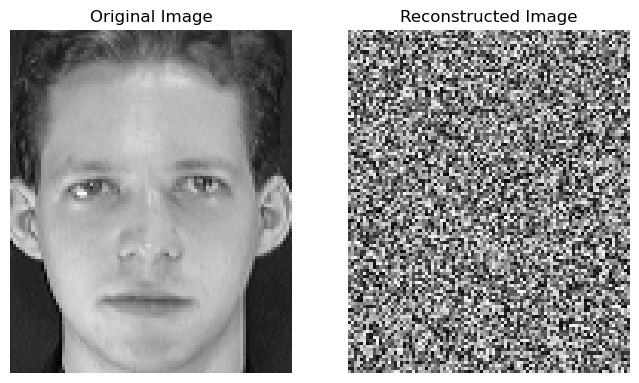

In [12]:

model = AutoEncoder(input_size=10304).to(device)

sample_idx = 0
sample_image = features[sample_idx]  # shape (10304,)
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)

model.eval()
with torch.no_grad():
    input_tensor = sample_image_tensor.unsqueeze(0)  
    
    reconstructed_tensor = model(input_tensor)  
    
    reconstructed_image = reconstructed_tensor.squeeze(0).cpu().numpy()

original_image = sample_image.reshape(112, 92)
reconstructed_image = reconstructed_image.reshape(112, 92)

plt.figure(figsize=(8,5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()

